In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import psycopg2
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style = 'darkgrid')

In [3]:
con = psycopg2.connect(dbname='mimic', user='sudarshan', host='/var/run/postgresql')

In [4]:
def plot_intervals(df, mdf, n_notes, n_adms):    
    fig, ax = plt.subplots(2, 1, figsize=(20, 20))

    sns.barplot(x='days', y='n_notes', data=df, ax=ax[0])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=45, ha='right', fontweight='bold', fontsize=12)
    ax[0].set_xlabel("")
    ax[0].set_ylabel('Number of notes', fontweight='bold', fontsize=15)
    ax[0].set_title('Distribution of notes and admissions w.r.t chart time and ICU admit time (in days)', fontweight='bold', fontsize=15)

    ax[0].text(len(df)/2, ax[0].get_ylim()[1]*0.80, f'Total number of notes = {n_notes}', fontweight='bold', fontsize=15, ha='center', va='bottom')

    for index, row in df.iterrows():
        ax[0].text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom', fontweight='bold', fontsize=12)

    sns.barplot(x='days', y='counts', hue='Legend', data=mdf, ax=ax[1])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=45, ha='right', fontweight='bold', fontsize=12)
    ax[1].set_xlabel("Time between note chart time and ICU admit time (days)\n 't' is the time-to-ICU admit time", fontweight='bold', fontsize=15)
    ax[1].set_ylabel('count', fontweight='bold', fontsize=15)

    ax[1].text(len(df)/2, ax[0].get_ylim()[1]*0.80, f'Total number of notes = {n_notes}\nTotal number of hospital admissions = {n_adms}', fontweight='bold', fontsize=15, ha='center', va='bottom')

    for index, row in mdf.iterrows():
        if index < len(mdf)//2:
            ax[1].text(index+0.04, row['counts'] + 100, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=12)
        else:
            ax[1].text(index % (len(mdf)//2) + 0.36, row['counts'] + 100, str(row['counts']), color='black', ha='right', va='bottom', fontweight='bold', fontsize=12)

In [5]:
query = """
select count(distinct text) as n_notes, count(distinct hadm_id) as n_adms from data group by chartinterval order by chartinterval;
"""

df = pd.read_sql_query(query, con)
intervals = [f'{i} < t < {i+1}' for i in range(15)]
intervals.append('t > 15')
df['days'] = intervals

# df.drop(0, axis=0, inplace=True)
# df.reset_index(inplace=True, drop=True)

mdf = df.copy()
mdf.rename(columns={'n_adms':'Number of Admissions', 'n_notes':'Number of Notes'}, inplace=True)
mdf = pd.melt(mdf, id_vars='days', var_name='Legend', value_name='counts')

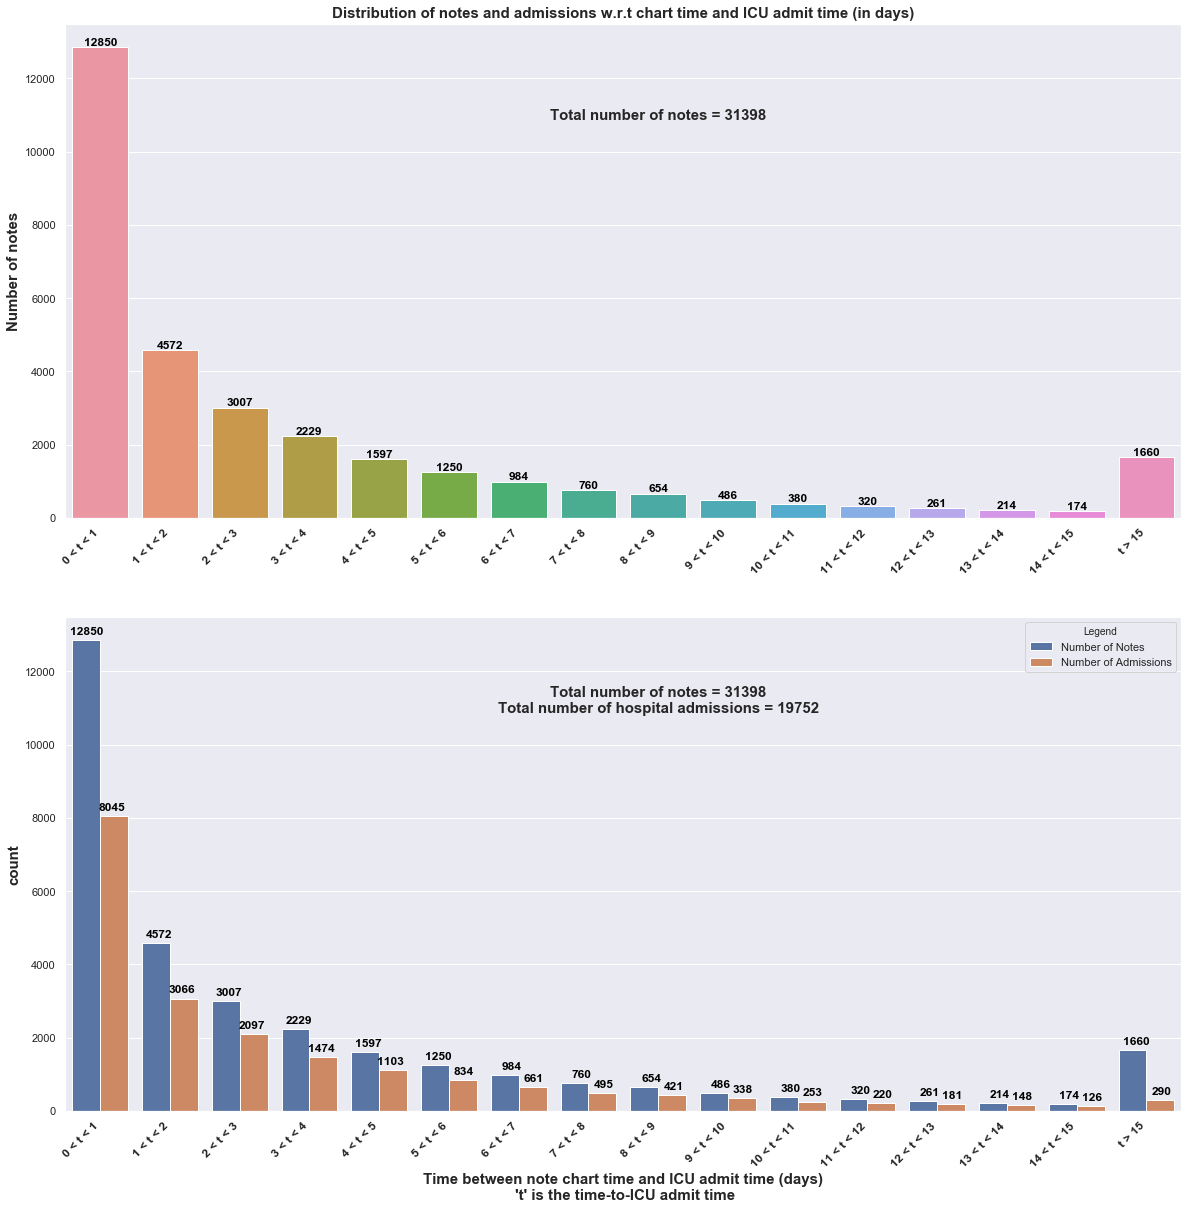

In [6]:
plot_intervals(df, mdf, df['n_notes'].sum(), df['n_adms'].sum())

In [7]:
query = """
select hadm_id, count(distinct text) as n_notes from data group by hadm_id order by hadm_id;
"""
df = pd.read_sql_query(query, con)
df.head()

,hadm_id,n_notes
0,100009,2
1,100012,2
2,100018,2
3,100020,2
4,100021,3


Text(10, 5530.56, 'Total number of hospital admissions = 10610')

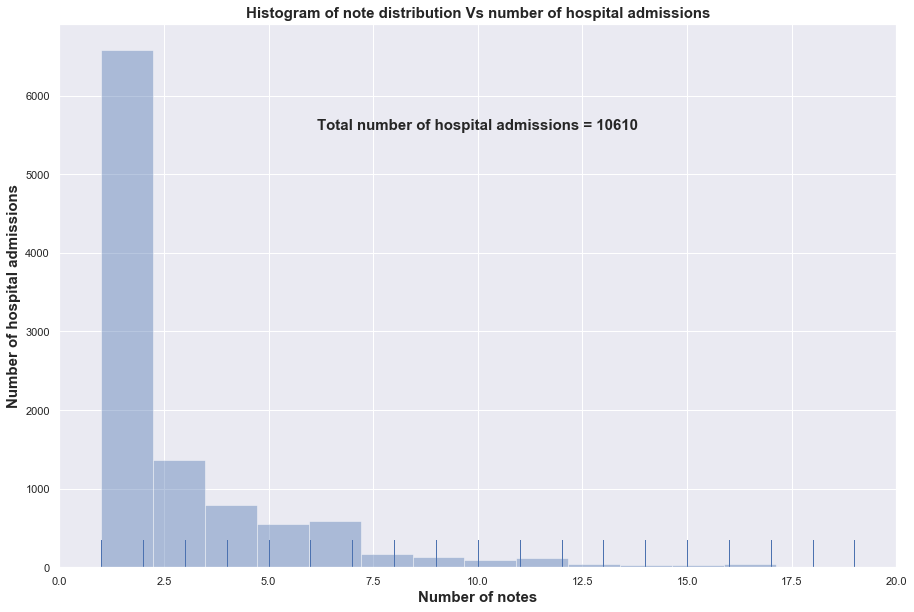

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(df['n_notes'], kde=False, ax=ax, rug=True, bins=50)
ax.set_xlabel('Number of notes', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_title('Histogram of note distribution Vs number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_xlim(0, 20)

ax.text(10, ax.get_ylim()[1]*0.80, f'Total number of hospital admissions = {len(df)}', fontweight='bold', fontsize=15, ha='center', va='bottom')

In [9]:
query = """
select hadm_id, avg(wait_period) as avg_wait_period from data group by hadm_id order by hadm_id;
"""
df = pd.read_sql_query(query, con)
df.head()

,hadm_id,avg_wait_period
0,100009,18.38
1,100012,47.07
2,100018,6.44
3,100020,21.22
4,100021,105.13


In [10]:
df['avg_wait_period'].min(), df['avg_wait_period'].mean(), df['avg_wait_period'].max()

(0.01, 86.84440716305372, 3269.1)

Text(300, 3605.2800000000007, 'Total number of hospital admissions = 10610')

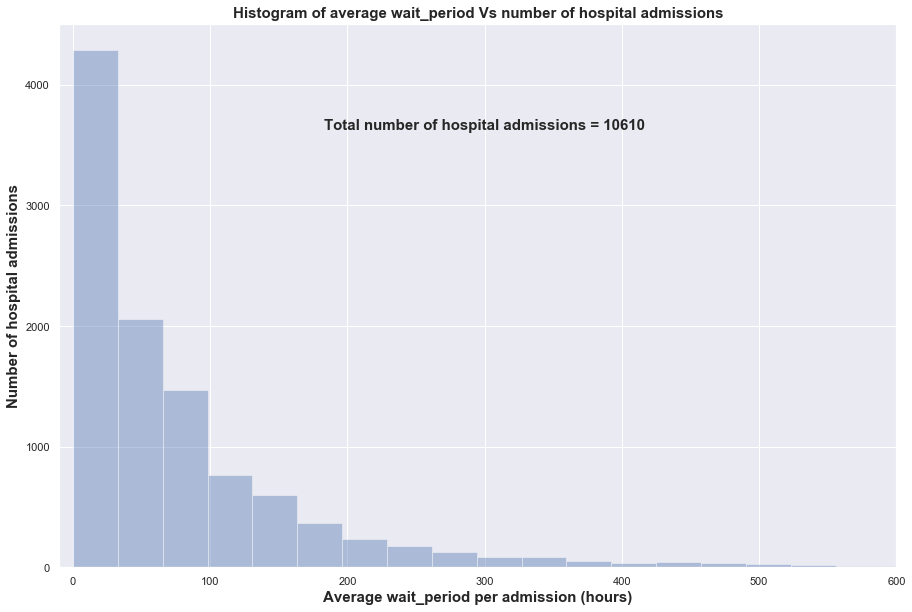

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(df['avg_wait_period'], kde=False, ax=ax, bins=100)
ax.set_xlabel('Average wait_period per admission (hours)', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_title('Histogram of average wait_period Vs number of hospital admissions', fontweight='bold', fontsize=15)
ax.set_xlim(-10, 600)

ax.text(300, ax.get_ylim()[1]*0.80, f'Total number of hospital admissions = {len(df)}', fontweight='bold', fontsize=15, ha='center', va='bottom')

In [12]:
query = """
with test as (select subject_id, count(distinct hadm_id) as n_adms from data group by subject_id order by subject_id) select n_adms, count(*) from test group by n_adms order by n_adms;
"""
df = pd.read_sql_query(query, con)
df.head()

,n_adms,count
0,1,9209
1,2,571
2,3,67
3,4,12
4,5,2


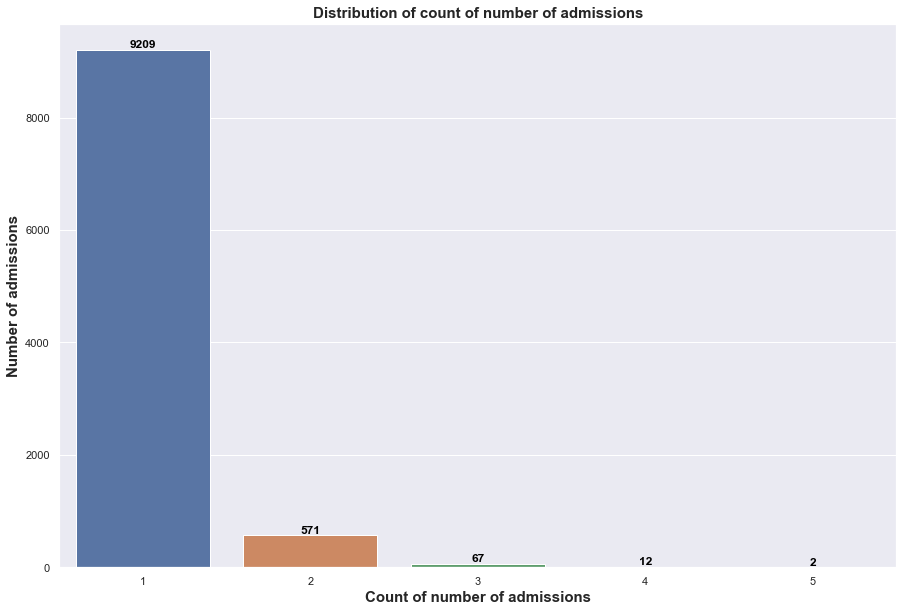

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x='n_adms', y='count', data=df, ax=ax)
ax.set_xlabel("Count of number of admissions", fontweight='bold', fontsize=15)
ax.set_ylabel('Number of admissions', fontweight='bold', fontsize=15)
ax.set_title('Distribution of count of number of admissions', fontweight='bold', fontsize=15)
for index, row in df.iterrows():
    ax.text(index, row['count'], str(row['count']), color='black', ha='center', va='bottom', fontweight='bold', fontsize=12)

In [14]:
query = """
with dtext as (select distinct text from data) select length(text) as note_length from dtext;
"""
df = pd.read_sql_query(query, con)
df.head()

,note_length
0,797
1,1093
2,1232
3,1766
4,1082


In [15]:
df['note_length'].min(), df['note_length'].mean(), df['note_length'].max(), df['note_length'].std()

(57, 1824.4864004076692, 20155, 1346.38109152831)

In [16]:
m = df['note_length'].mean()
s = df['note_length'].std()

In [17]:
print(f"{m - s:0.2f}, {m + 2*s:0.2f}")

478.11, 4517.25


Text(4500, 5087.040000000001, 'Total number of notes = 31398\nmin = 57, average = 1824.49, max = 20155')

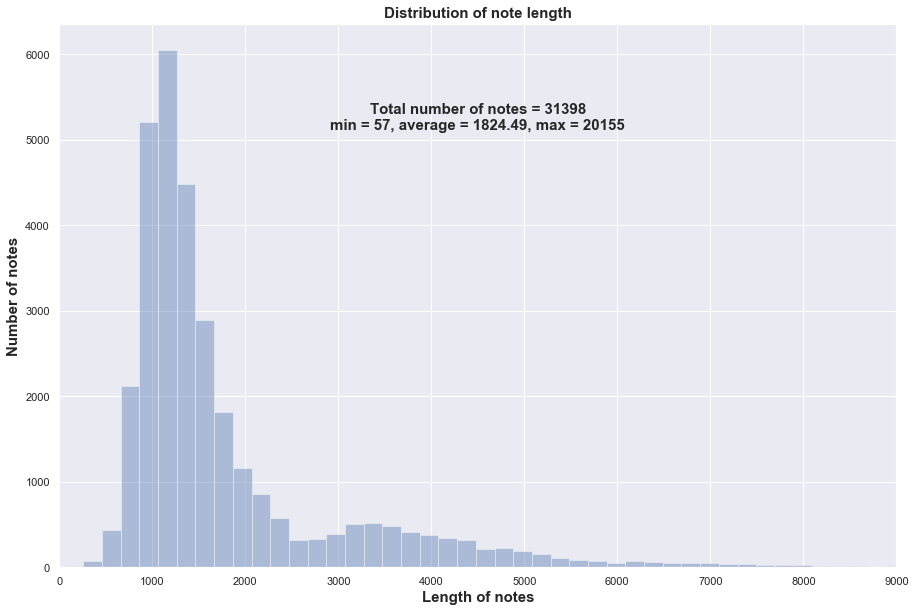

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.distplot(df['note_length'], kde=False, ax=ax, bins=100)
ax.set_xlabel('Length of notes', fontweight='bold', fontsize=15)
ax.set_ylabel('Number of notes', fontweight='bold', fontsize=15)
ax.set_title('Distribution of note length', fontweight='bold', fontsize=15)
ax.set_xlim(0, 9000)

ax.text(4500, ax.get_ylim()[1]*0.80, f"Total number of notes = {len(df)}\nmin = {df['note_length'].min()}, average = {df['note_length'].mean():0.2f}, max = {df['note_length'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')

In [19]:
con.close()